## Projekt 2

Zbiór danych: CIFAR-10 obrazki kolorowe, 70000 próbek, 10 klas

Celem projektu jest porównanie dwóch klasyfikatorów: klasyfikatora SVM użytego dla danych wygenerowanych przez prostą sieć CNN oraz klasyfikatora MLP. 

Trenujemy prostą kilkuwarstwową sieć CNN dla 4 czasów trenowania: bardzo krótki, krótki, średni, pełny. Sieć taką można łatwo znaleźć. (sieć CNN składa się z części konwolucyjnej i MLP, dlatego wyniki dla klasyfikatora MLP będą takie same jak dla całej sieci CNN).

Po zadanych czasach trenowania t1, t2, t3, t4, zrzucić wektory reprezentujące obrazki które wchodzą na sieć MLP. Te wektory użyć do klasyfikacji metodą SVM. 

Wyniki jakości klasyfikatorów oceniać na bazie krzyżowej-walidacji, (accuracy - Loss-błąd, Krzywa ROC, Precision-Recall, (pola pod krzywymi) F1). Dokonać porównania wyników tzn: accuracy i loss dla trzech budżetów czasowych T1, T2, T3 (krótki, średni, długi). Tym sposobem porównać jakość klasyfikatorów tj. pełnej, uczonej sieci CNN w zadanych czasach oraz tej „kombinowanej” z SVM. 

Należy sporządzić raport z projektu.

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.base import ClassifierMixin
from sklearn.model_selection import train_test_split
import seaborn

import math
import time
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, auc

import pandas as pd
import seaborn as sns
import random
import matplotlib
import warnings
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, plot_roc_curve, roc_curve,
                             precision_recall_curve, plot_precision_recall_curve, f1_score, average_precision_score, 
                             hinge_loss, precision_score, recall_score)
from sklearn.model_selection import train_test_split, cross_val_score
from imgaug import augmenters as iaa
from sklearn.svm import LinearSVC
from IPython.display import display

from keras import backend as K
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


### const

In [2]:
batch_size = 32
num_classes = 10
epochs = 3
num_predictions = 20

### functions

In [3]:
def train_model(model, x_train, y_train, batch_size, epochs, x_test, y_test):
    return model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test))

def print_plots(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
def print_roc(fpr, tpr):
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc(fpr, tpr)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
def maximum_predict(data):
    out = []
    for item in data:
        i = 0
        for sub_item in item:
            if sub_item == 1:
                out.append(i)
                break;
            i += 1
    return out

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
# Convert class vectors to binary class matrices.
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# simple normalisation
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train = x_train[:10000]
x_test = x_test[:10000]
y_train = y_train[:10000]
y_test = y_test[:10000]

In [6]:
# definiton of CNN model

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [7]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6),
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)       

In [8]:
history = train_model(model, x_train, y_train, batch_size, epochs, x_test, y_test)

Train on 10000 samples, validate on 10000 samples
Epoch 1/3
10000/10000 [==============================] - 17s 2ms/step - loss: 2.1548 - accuracy: 0.1936 - val_loss: 1.9321 - val_accuracy: 0.3129
Epoch 2/3
10000/10000 [==============================] - 17s 2ms/step - loss: 1.8518 - accuracy: 0.3216 - val_loss: 1.7249 - val_accuracy: 0.3887
Epoch 3/3
10000/10000 [==============================] - 15s 2ms/step - loss: 1.7159 - accuracy: 0.3719 - val_loss: 1.6882 - val_accuracy: 0.3945


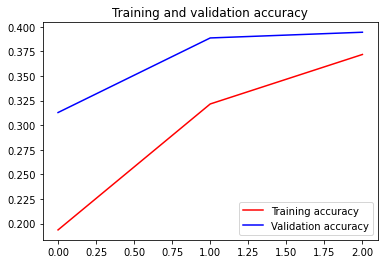

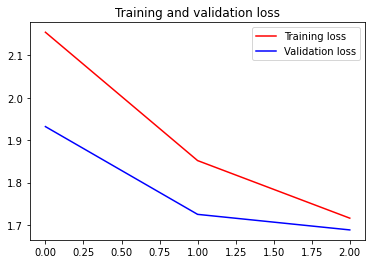

10000/10000 [==============================] - 3s 255us/step
Test loss: 1.688199105834961
Test accuracy: 0.3944999873638153


In [9]:
print_plots(history)
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

              precision    recall  f1-score   support

           0       0.45      0.46      0.45      1000
           1       0.36      0.77      0.49      1000
           2       0.38      0.12      0.18      1000
           3       0.33      0.09      0.14      1000
           4       0.44      0.21      0.29      1000
           5       0.49      0.22      0.30      1000
           6       0.36      0.62      0.46      1000
           7       0.38      0.51      0.43      1000
           8       0.44      0.55      0.49      1000
           9       0.40      0.39      0.39      1000

    accuracy                           0.39     10000
   macro avg       0.40      0.39      0.36     10000
weighted avg       0.40      0.39      0.36     10000



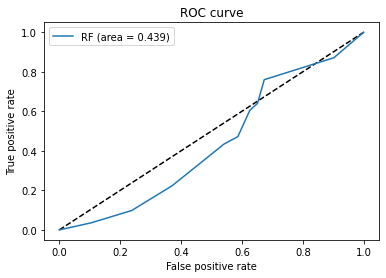

In [10]:
test_preds = model.predict_classes(x_test)
predict_result = [item for item in test_preds]
correct = maximum_predict(y_test)

print(classification_report(correct, predict_result))

fpr, tpr, thresholds = roc_curve(correct, predict_result, pos_label=2)

print_roc(fpr, tpr)

### SVM

In [11]:
def get_layer_output(index, data):
    return K.function([model.layers[0].input], [model.layers[index].output])(data)[0]

layer_output = get_layer_output(16, x_train)
clf = SVC(kernel='linear', C=10)

clf.fit(layer_output, correct)
pred = clf.predict(layer_output)

Accouracy: 0.117
hinge function loss: 5.3208030273696565
recall score: 0.117
f1 score: 0.117
precision_score: 0.117


/media/DATA/studia/ML/project/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'binary') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


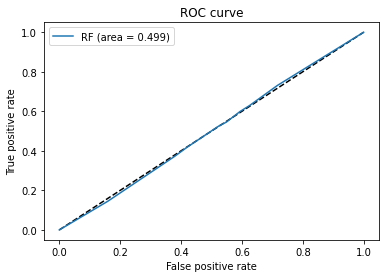

In [12]:
score = clf.score(layer_output, correct)
print(f'Accouracy: {score}')

predict = clf.decision_function(layer_output)
score = hinge_loss(correct, predict)
print(f'hinge function loss: {score}')

score = recall_score(correct, pred, pos_label="binary", average="micro")
print(f'recall score: {score}')

score = f1_score(correct, pred, pos_label="binary", average="micro")
print(f'f1 score: {score}')

score = precision_score(correct, pred, pos_label="binary", average="micro")
print(f'precision_score: {score}')

fpr, tpr, thresholds = roc_curve(correct, pred, pos_label=2)
print_roc(fpr, tpr)

In [13]:
clf = SVC(kernel='rbf', C=10)

clf.fit(layer_output, correct)
pred = clf.predict(layer_output)

Accouracy: 0.1718
hinge function loss: 4.479916123417816
recall score: 0.1718
f1 score: 0.1718
precision_score: 0.1718


/media/DATA/studia/ML/project/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'binary') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


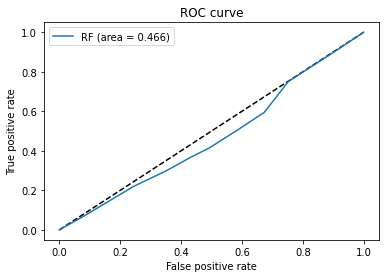

In [14]:
score = clf.score(layer_output, correct)
print(f'Accouracy: {score}')

predict = clf.decision_function(layer_output)
score = hinge_loss(correct, predict)
print(f'hinge function loss: {score}')

score = recall_score(correct, pred, pos_label="binary", average="micro")
print(f'recall score: {score}')

score = f1_score(correct, pred, pos_label="binary", average="micro")
print(f'f1 score: {score}')

score = precision_score(correct, pred, pos_label="binary", average="micro")
print(f'precision_score: {score}')

fpr, tpr, thresholds = roc_curve(correct, pred, pos_label=2)
print_roc(fpr, tpr)